This notebook is for creating the base ML model.

In [1]:
model_name = "eval_metric_rmsse" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [4]:
df.shape

(7319643, 3)

In [5]:
df.head()

datetime  location  busyness
0 2021-01-01         3       132
1 2021-01-01         4       234
2 2021-01-01         5        19
3 2021-01-01         6        37
4 2021-01-01         7       493

In [6]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01       132
4       2021-01-01       234
5       2021-01-01        19
6       2021-01-01        37
7       2021-01-01       493


In [7]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [8]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="RMSSE",
    prediction_length=prediction_length,
    path=model_name
)
print('we made the predictor')

we made the predictor


In [9]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'eval_metric_rmsse_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       7.99 GB / 15.90 GB (50.3%)
Disk Space Avail:   2138.54 GB / 2794.50 GB (76.5%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSSE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%)

In [10]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.131207     768.705909          94.204535          7
1     SeasonalNaive  -1.364405       1.086374           4.720141          2
2             Theta  -1.509156      53.078059           4.841482          6
3     DirectTabular  -1.743394      16.176811          75.924284          4
4  RecursiveTabular  -1.902801     694.482136         378.963176          3
5             Naive  -2.028540       3.882529           4.792571          1
6               ETS -24.567652     207.115887           4.815643          5


In [11]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  146.290086  114.056994  125.059251  132.998874   
        2024-01-02 00:00:00   90.184402   52.231866   65.230103   74.593824   
        2024-01-02 01:00:00  109.306695   67.014454   81.488281   91.901438   
        2024-01-02 02:00:00   94.958738   49.192859   64.832160   76.144512   
        2024-01-02 03:00:00   61.706520   12.645980   29.433996   41.569022   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.156083  -13.667426   -8.564965   -4.881204   
        2022-04-23 14:00:00    1.138397  -13.688230   -8.582983   -4.897290   
        2022-04-23 15:00:00    1.135802  -13.695116   -8.587207   -4.903150   
        2022-04-23 16:00:00    1.131661  -13.703975   -8.591864   -4.907491   
        2022-04-23 17:00:00    1.143982  -13.708268 

data with frequency 'None' has been resampled to frequency 'h'.


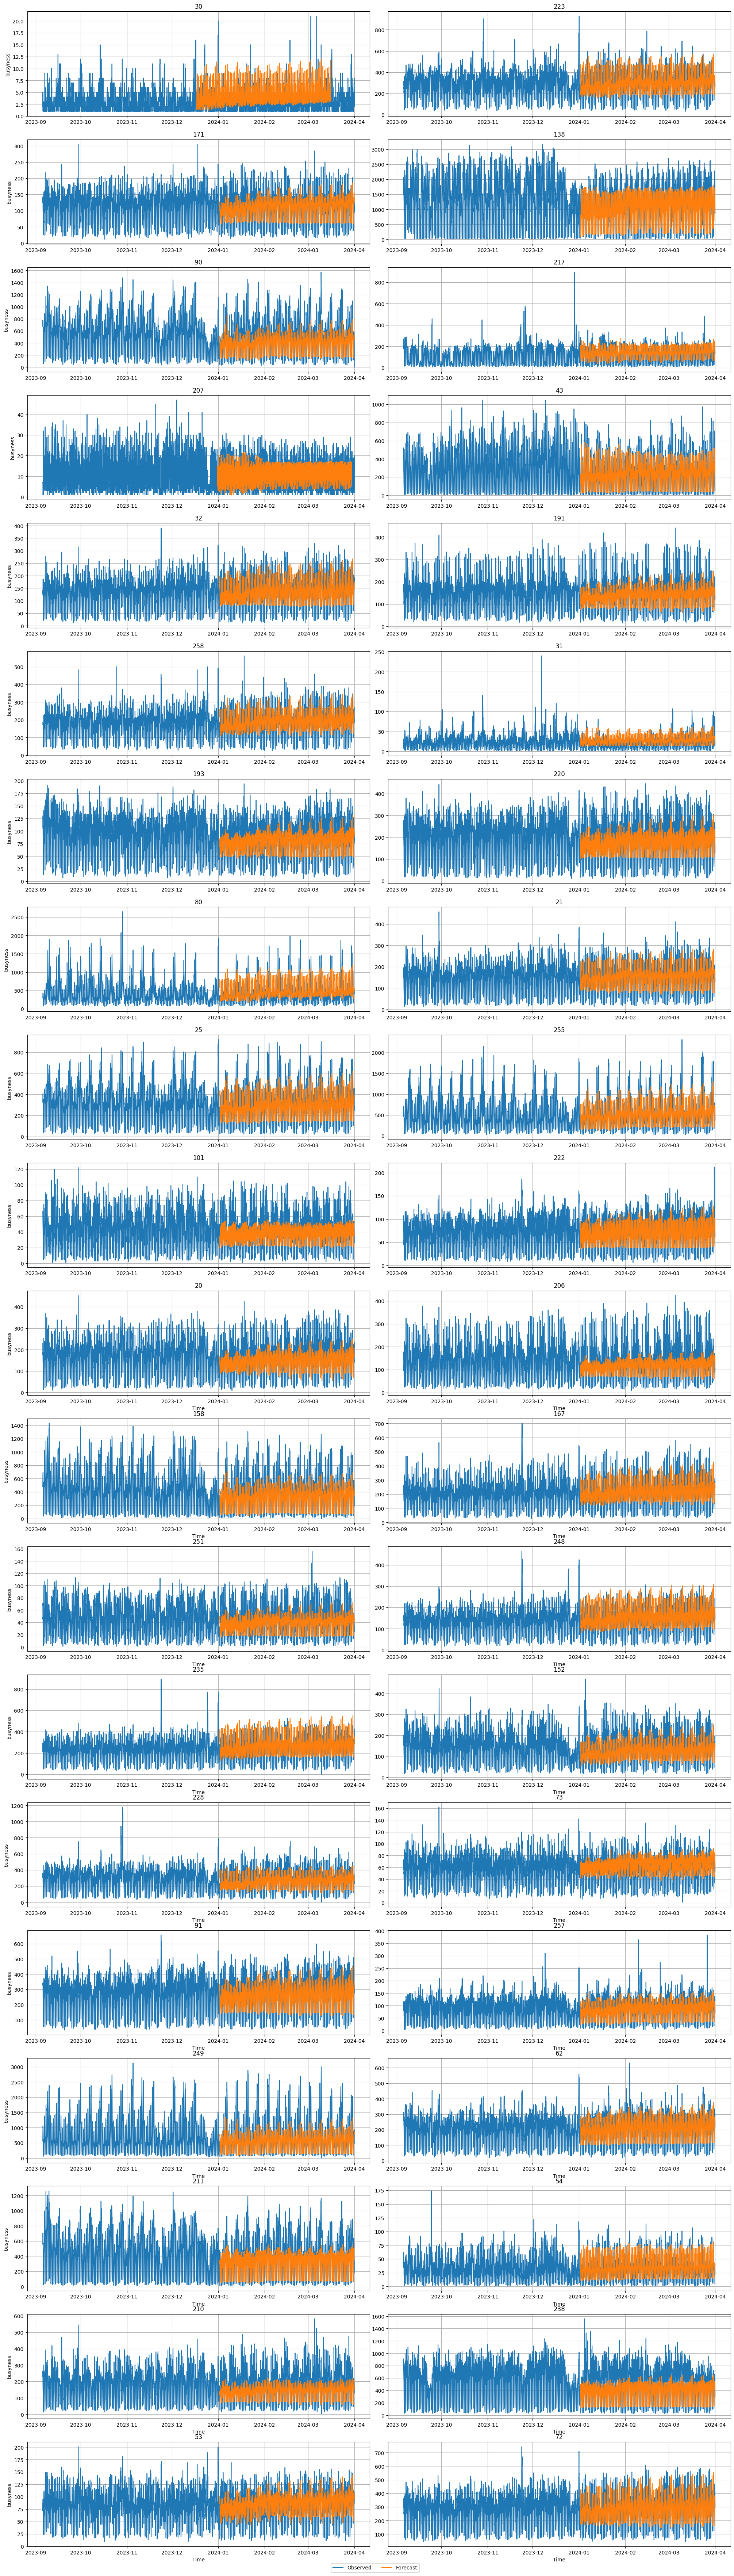

In [12]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=40)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


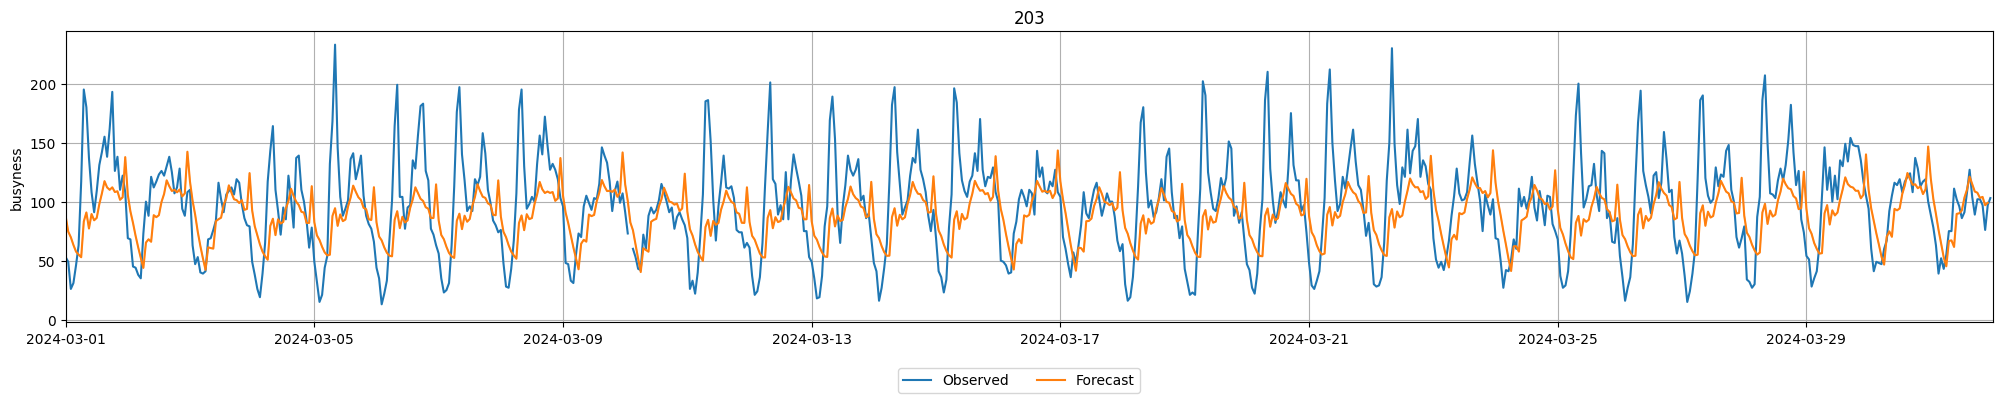

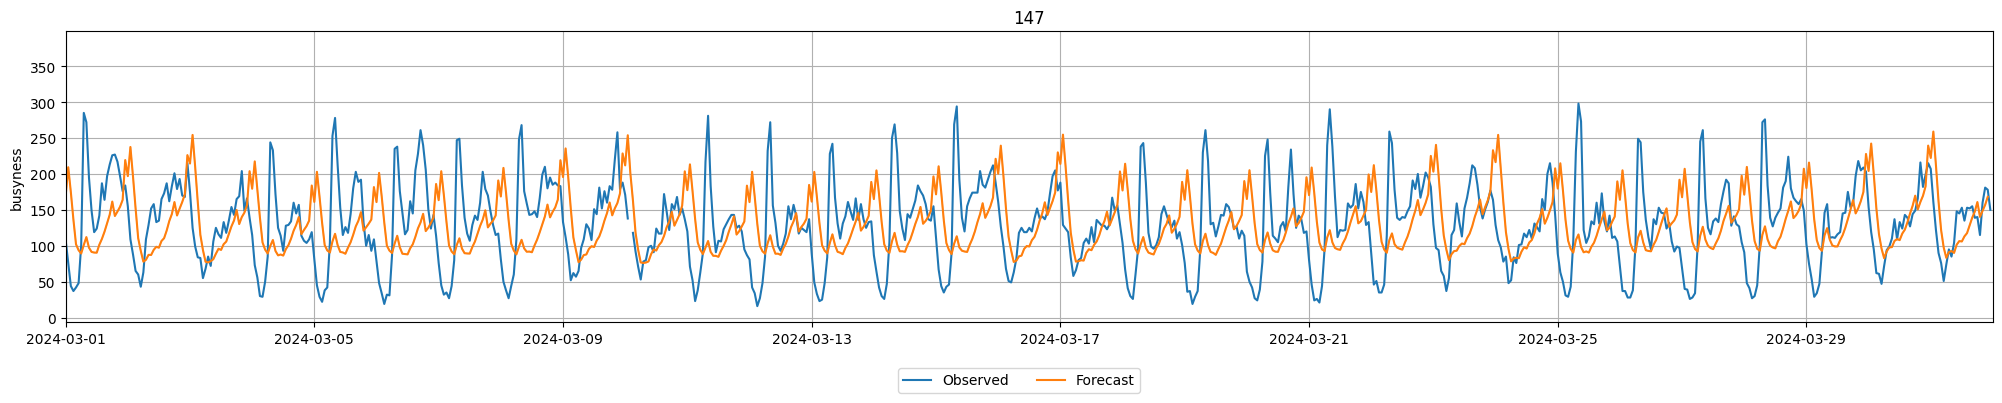

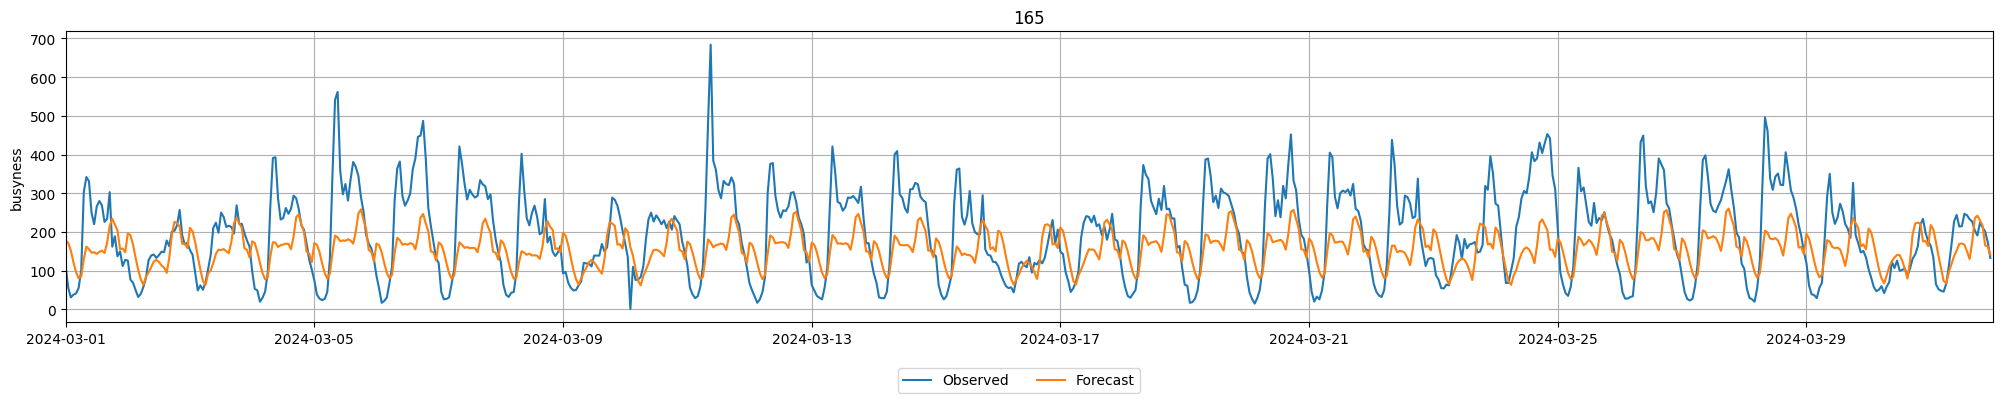

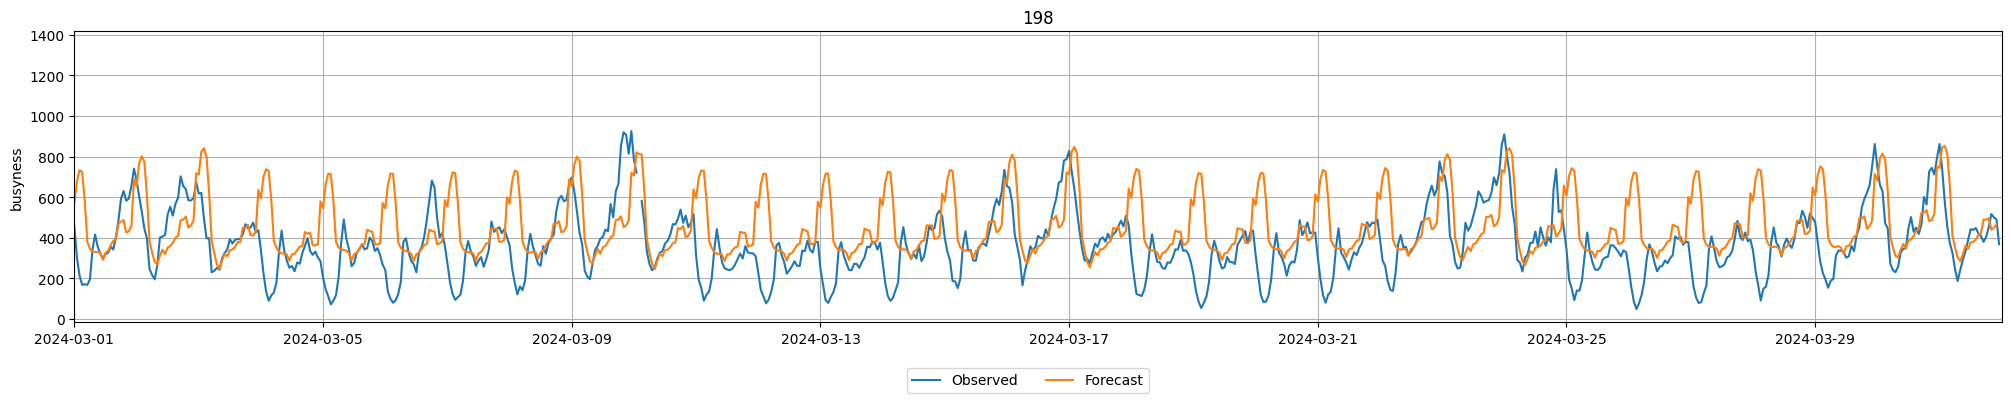

In [13]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [14]:
plt.show()

In [15]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'RMSSE': -1.793974340339881}